# QC protocol for Private Weather Stations

This notebook presents how to use the Python package `pypwsqc`, a quality assurance protocol developed for automated private weather stations (PWS). The protocol consists of three filters; the Faulty Zero filter, the High Influx filter and the Station Outlier filter.

The package is based on the original R code available at https://github.com/LottedeVos/PWSQC/.

Publication: de Vos, L. W., Leijnse, H., Overeem, A., & Uijlenhoet, R. (2019). Quality control for crowdsourced personal weather stations to enable operational rainfall monitoring. Geophysical Research Letters, 46(15), 8820-8829

`pypwsqc` depends on the `poligrain`, `xarray`, `pandas` and `numpy` packages. Make sure to install and import the required packages first.

In [1]:
import poligrain as plg
import xarray as xr
import numpy as np
import pandas as pd

# import pypwsqc

## Remove cells below before pushing !!!!!!

In [2]:
import matplotlib.pyplot as plt

In [3]:
ds_pws = xr.open_dataset('C:/Users/a002461/OPENSENSE/data/OpenSense_PWS_data_HI_FZ_filtered_rainfall.nc')

# slice to one month
#ds_pws = ds_pws.sel(time = slice('2017-07-01','2017-07-31'))

In [4]:
ds_pws

<xarray.Dataset>
Dimensions:               (time: 219168, id: 134)
Coordinates:
  * time                  (time) datetime64[ns] 2016-05-01T00:05:00 ... 2018-...
  * id                    (id) <U6 'ams1' 'ams2' 'ams3' ... 'ams133' 'ams134'
    elevation             (id) <U3 ...
    latitude              (id) float64 ...
    longitude             (id) float64 ...
    x                     (id) float64 ...
    y                     (id) float64 ...
Data variables:
    rainfall              (id, time) float64 ...
    nbrs_not_nan          (id, time) int32 ...
    reference             (id, time) float64 ...
    fz_flag               (id, time) int32 ...
    hi_flag               (id, time) int32 ...
    fz_filtered_rainfall  (id, time) float64 ...
    hi_filtered_rainfall  (id, time) float64 ...
Attributes:
    title:                 PWS data from Amsterdam
    file author:           Maximilian Graf
    institution:           Wageningen University and Research, Department of ...
    date:                  2022-10-18 10:32:00
    source:                Netamo PWS
    history:               Data derived and reformated from the originally pu...
    naming convention:     OpenSense-0.1
    license restrictions:  CC-BY 4.0 https://creativecommons.org/licenses/by/...
    reference:             https://doi.org/10.1029/2019GL083731
    comment:

## Download example data

In this example, we use an open PWS dataset from Amsterdam, called the "AMS PWS" dataset. By running the cell below, an example NetCDF-file will be downloaded to your current repository (if your machine is connected to the internet).

In [ ]:
!curl -OL https://github.com/OpenSenseAction/OS_data_format_conventions/raw/main/notebooks/data/OpenSense_PWS_example_format_data.nc

## Data preparations

This package handles rainfall data as `xarray`  Datasets. The data set must have `time` and `id` dimensions, `latitude` and `longitude` as coordinates, and `rainfall` as data variable.

An example of how to convert .csv data to a `xarray` dataset is found [here](https://github.com/OpenSenseAction/OS_data_format_conventions/blob/main/notebooks/PWS_example_dataset.ipynb).

In [ ]:
ds_pws = xr.open_dataset("OpenSense_PWS_example_format_data.nc")
ds_pws

### Reproject coordinates 

First we reproject the coordinates to a local metric coordinate reference system to allow for distance calculations. In the Amsterdam example we use EPSG:25832. **Remember to use a local metric reference system for your use case!** We use the function `spatial.project_point_coordinates` in the `poligrain`package. 

In [5]:
ds_pws.coords["x"], ds_pws.coords["y"] = plg.spatial.project_point_coordinates(
    x=ds_pws.longitude, y=ds_pws.latitude, target_projection="EPSG:25832"
)

### Create distance matrix

Then, we calculate the distances between all stations in our data set. If your data set has a large number of stations this can take some time.

In [6]:
distance_matrix = plg.spatial.calc_point_to_point_distances(ds_pws, ds_pws)

### Calculate data variables 

Next, we will calculate the data variables `nbrs_not_nan` and `reference` that are needed to perform the quality control. If you have already processed your data with the FZ and HI-filters, your `xarray` data set already have these variables and you can proceed to the next section.

`nbrs_not_nan`:
Number of neighbours within a specificed range `max_distance` around the station that are reporting rainfall for each time step. The selected range depends on the use case and area of interest. In this example we use 10'000 meters. 

 `reference`:
Median rainfall of all stations within range `max_distance` from each station.

`max_distance` is called 'd' in the original publication.

### Select considered range around each station

In [7]:
max_distance = 10e3

In [ ]:
%%time
ds_pws = ds_pws.load()

nbrs_not_nan = []
reference = []

for pws_id in ds_pws.id.data:
    neighbor_ids = distance_matrix.id.data[
        (distance_matrix.sel(id=pws_id) < max_distance)
        & (distance_matrix.sel(id=pws_id) > 0)
    ]

    N = ds_pws.rainfall.sel(id=neighbor_ids).notnull().sum(dim="id")
    nbrs_not_nan.append(N)

    median = ds_pws.sel(id=neighbor_ids).rainfall.median(dim="id")
    reference.append(median)

ds_pws["nbrs_not_nan"] = xr.concat(nbrs_not_nan, dim="id")
ds_pws["reference"] = xr.concat(reference, dim="id")

### Initialize data variables

We initialize data variables for the resulting SO-flags and the median pearson correlation with neighboring stations with the value -999. If the variables have the value 0 (passed the test), 1 (did not pass the test) or -1 (not enough information) after running the SO-filter, we know that these time series have been evaluated. If the value is still -999, this means that something went wrong as the data has not been processed. 

We also save the threshold `gamma` as a variable. In this way we can easily visualize if the median correlation with neighbors drops below this threshold, which is the condition for raising a SO-flag (see below).

In [8]:
gamma = 0.15

In [9]:
ds_pws['so_flag'] = xr.DataArray(np.ones((len(ds_pws.id), len(ds_pws.time)))*-999, dims=("id", "time"))
ds_pws['median_corr_nbrs'] = xr.DataArray(np.ones((len(ds_pws.id), len(ds_pws.time)))*-999, dims=("id", "time"))
ds_pws['gamma'] = xr.DataArray(np.ones((len(ds_pws.id), len(ds_pws.time)))*gamma, dims=("id", "time"))

## Quality control

Now the data set is prepared to run the quality control.

### Apply Station Outlier filter

Conditions for raising Station Outlier flag:

* Median of the rolling pearson correlation with all neighboring stations within range `max_distance` is less than threshold `gamma`
* Filter cannot be applied if less than `nstat` neighbours are reporting data (SO flag is set to -1)
*  **Filter cannot be applied if there are less than `nstat` neighbours with less than `mmatch` intervals overlapping with the evaluated station(SO flag is set to -1)**

For settings for parameter `mint`, `mrain`, `mmatch`, `gamma`, and `nstat`, see table 1 in https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019GL083731 

Note! The SO-filter is different compared with the original R-code. In its original implementation, any interval with at least `mrain` intervals of nonzero rainfall measurements is evaluated. In this implementation, only a fixed rolling window of `mint` intervals is evaluated. 

`max_distance` is called 'd' in the original publication.


## Preparations

In [10]:
# Set parameters
mint = 8064  #  4032
# mrain = 100
mmatch = 100
gamma = 0.17 # 0.15
beta = 0.2
n_stat = 5
max_distance = 10e3 

## SO-filter

In [15]:
def so_filter_OLD(da_station, da_neighbors, window_length):
    
    s_station = da_station.to_series()
    s_neighbors = da_neighbors.to_series()

    #create dataframe of neighboring stations
    df = da_neighbors.to_dataframe()
    df = df["rainfall"].unstack("id")

    corr = s_station.rolling(window_length, min_periods= 1).corr(s_neighbors)

    # number of matching rainy time steps in evaluation period
    number_of_rainy_neighbors  = (df > 0).sum(axis=1)
    rainy_timestep_at_station = s_station > 0

    matches = number_of_rainy_neighbors.where(rainy_timestep_at_station).rolling(mint, min_periods=1).sum()
    ds = xr.Dataset.from_dataframe(pd.DataFrame({'corr': corr}))
    ds['matches'] = xr.DataArray.from_series(matches)
    
    return ds

In [11]:
def so_filter(da_station, da_neighbors, window_length):

    # rolling pearson correlation
    s_station = da_station.to_series()
    s_neighbors = da_neighbors.to_series()
    corr = s_station.rolling(window_length, min_periods= 1).corr(s_neighbors)
    ds = xr.Dataset.from_dataframe(pd.DataFrame({'corr': corr}))

    # create dataframe of neighboring stations
    df = da_neighbors.to_dataframe()
    df = df["rainfall"].unstack("id")

    # boolean arrays - True if a rainy time step, False if 0 or NaN.
    rainy_timestep_at_nbrs = (df > 0)
    
    # rolling sum of number of rainy timesteps in last mint period, per neighbor. 
    wet_timesteps_last_mint_period = rainy_timestep_at_nbrs.rolling(mint, min_periods=1).sum()
    
    # per time step and neighbor, does the nbr have more than mmatch wet time steps in the last mint period? (true/false)
    enough_matches_per_nbr = (wet_timesteps_last_mint_period > mmatch)
    
    # summing how many neighbors that have enough matches per time step
    nr_nbrs_with_enough_matches = enough_matches_per_nbr.sum(axis = 1)

    ds['matches'] = xr.DataArray.from_series(nr_nbrs_with_enough_matches)
    
    return ds

In [18]:
%%time
i = 30
ds_station = ds_pws.isel(id=i) 
da_station = ds_station.rainfall

pws_id = ds_station.id.values

# picking stations within max_distnance, excluding itself, for the whole duration of the time series
neighbor_ids = distance_matrix.id.data[(distance_matrix.sel(id=pws_id) < max_distance) & (distance_matrix.sel(id=pws_id) > 0)]

#create data set for neighbors
ds_neighbors = ds_pws.sel(id=neighbor_ids)

da_neighbors = ds_neighbors.rainfall

#create dataframe of neighboring stations
df = da_neighbors.to_dataframe()

#this is a df with the rainfall time series of all nbrs
df = df["rainfall"].unstack("id")

# "boolean" df. True if a rainy time step, False if 0 or NaN.
rainy_timestep_at_nbrs = (df > 0)

# rolling sum of number of rainy timesteps in last mint period, per neighbor. 
wet_timesteps_last_mint_period = rainy_timestep_at_nbrs.rolling(mint, min_periods=1).sum()

# per time step and neighbor, does the nbr have more than mmatch wet time steps in the last mint period? (true/false)
enough_matches_per_nbr = (wet_timesteps_last_mint_period > mmatch)

# summing how many neighbors that have enough matches 
nr_nbrs_with_enough_matches = enough_matches_per_nbr.sum(axis = 1)

# filter can be applied if there is more than five neighbors
more_than_nstat_nbrs = (nr_nbrs_with_enough_matches > n_stat)

# filter can NOT be applied if less than n_stat neighbors have enough matches

CPU times: total: 58.5 s
Wall time: 59.5 s


In [21]:
ds_neighbors.id

<xarray.DataArray 'id' (id: 90)>
array(['ams4', 'ams5', 'ams14', 'ams16', 'ams17', 'ams18', 'ams19', 'ams20',
       'ams22', 'ams23', 'ams24', 'ams25', 'ams26', 'ams27', 'ams28', 'ams29',
       'ams30', 'ams32', 'ams33', 'ams34', 'ams35', 'ams36', 'ams37', 'ams38',
       'ams39', 'ams40', 'ams41', 'ams42', 'ams43', 'ams44', 'ams45', 'ams46',
       'ams47', 'ams48', 'ams49', 'ams50', 'ams51', 'ams52', 'ams53', 'ams54',
       'ams55', 'ams56', 'ams57', 'ams58', 'ams59', 'ams60', 'ams61', 'ams62',
       'ams63', 'ams64', 'ams65', 'ams66', 'ams67', 'ams68', 'ams69', 'ams70',
       'ams71', 'ams72', 'ams73', 'ams74', 'ams75', 'ams76', 'ams77', 'ams78',
       'ams79', 'ams80', 'ams81', 'ams83', 'ams84', 'ams85', 'ams86', 'ams87',
       'ams89', 'ams90', 'ams91', 'ams92', 'ams93', 'ams94', 'ams95', 'ams96',
       'ams97', 'ams98', 'ams99', 'ams101', 'ams102', 'ams103', 'ams104',
       'ams105', 'ams106', 'ams107'], dtype='<U6')
Coordinates:
  * id         (id) <U6 'ams4' 'ams5' 'ams14' ... 'ams105' 'ams106' 'ams107'
    elevation  (id) <U3 ...
    latitude   (id) float64 52.35 52.32 52.38 52.38 ... 52.36 52.38 52.36 52.39
    longitude  (id) float64 4.678 4.679 4.727 4.744 ... 4.926 4.929 4.929 4.93
    x          (id) float64 2.056e+05 2.055e+05 ... 2.229e+05 2.231e+05
    y          (id) float64 5.808e+06 5.805e+06 ... 5.809e+06 5.812e+06

### SCRIBBLES

In [20]:
i

30

In [40]:
number_of_rainy_neighbors  = (df > 0).sum(axis=1)

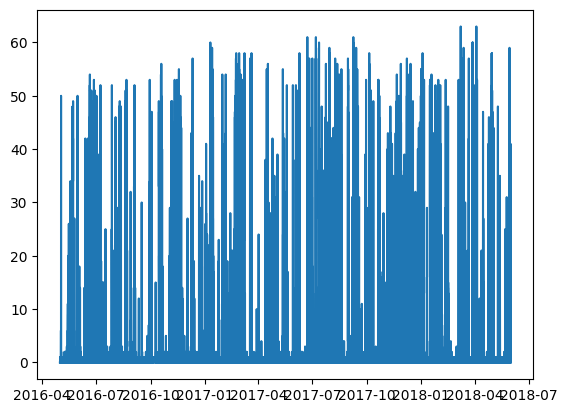

In [45]:
plt.plot(number_of_rainy_neighbors)


In [48]:
rainy_timestep_at_nbrs = (df > 0)

In [69]:
rainy_timestep_at_nbrs

id,ams4,ams5,ams14,ams16,ams17,ams18,ams19,ams20,ams22,ams23,...,ams97,ams98,ams99,ams101,ams102,ams103,ams104,ams105,ams106,ams107
time,,,,,,,,,,,,,,,,,,,,,
2016-05-01 00:05:00,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2016-05-01 00:10:00,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2016-05-01 00:15:00,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2016-05-01 00:20:00,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2016-05-01 00:25:00,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-05-31 23:40:00,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2018-05-31 23:45:00,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2018-05-31 23:50:00,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


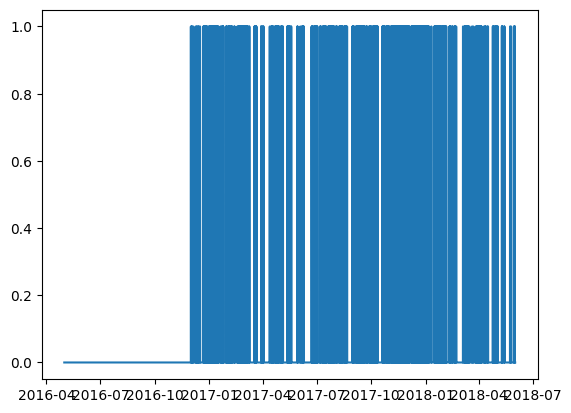

In [54]:
plt.plot(rainy_timestep_at_nbrs["ams4"])

In [51]:
wet_timesteps_last_mint_period = rainy_timestep_at_nbrs.rolling(mint, min_periods=1).sum()

In [52]:
wet_timesteps_last_mint_period 

id,ams4,ams5,ams14,ams16,ams17,ams18,ams19,ams20,ams22,ams23,...,ams97,ams98,ams99,ams101,ams102,ams103,ams104,ams105,ams106,ams107
time,,,,,,,,,,,,,,,,,,,,,
2016-05-01 00:05:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-05-01 00:10:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-05-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-05-01 00:20:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-05-01 00:25:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-05-31 23:40:00,68.0,58.0,158.0,128.0,137.0,0.0,45.0,58.0,73.0,71.0,...,109.0,70.0,112.0,88.0,0.0,105.0,0.0,10.0,84.0,112.0
2018-05-31 23:45:00,68.0,58.0,158.0,128.0,137.0,0.0,45.0,58.0,73.0,71.0,...,109.0,70.0,112.0,88.0,0.0,105.0,0.0,10.0,84.0,112.0
2018-05-31 23:50:00,68.0,58.0,158.0,128.0,137.0,0.0,45.0,58.0,73.0,71.0,...,109.0,70.0,112.0,88.0,0.0,105.0,0.0,10.0,84.0,112.0


In [61]:
enough_matches_per_nbr = (wet_timesteps_last_mint_period > mmatch)

In [62]:
enough_matches_per_nbr

id,ams4,ams5,ams14,ams16,ams17,ams18,ams19,ams20,ams22,ams23,...,ams97,ams98,ams99,ams101,ams102,ams103,ams104,ams105,ams106,ams107
time,,,,,,,,,,,,,,,,,,,,,
2016-05-01 00:05:00,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2016-05-01 00:10:00,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2016-05-01 00:15:00,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2016-05-01 00:20:00,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2016-05-01 00:25:00,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-05-31 23:40:00,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2018-05-31 23:45:00,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2018-05-31 23:50:00,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [66]:
nr_nbrs_with_enough_matches = enough_matches_per_nbr.sum(axis = 1)

In [71]:
SO_can_be_applied = (nr_nbrs_with_enough_matches > 5)

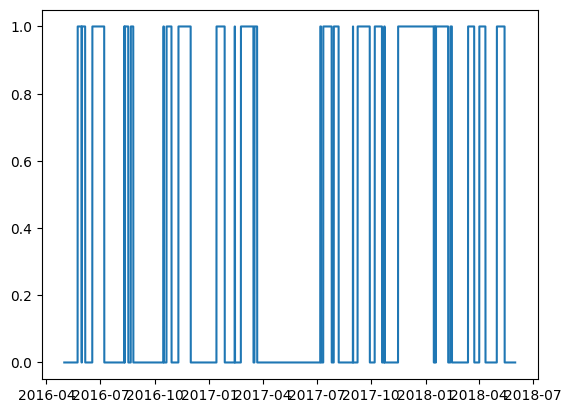

In [72]:
plt.plot(SO_can_be_applied)

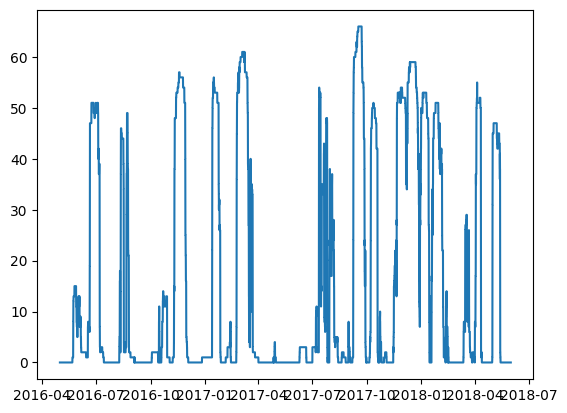

In [68]:
plt.plot(nr_nbrs_with_enough_matches)

In [ ]:
matches = number_of_rainy_neighbors.where(rainy_timestep_at_station).rolling(mint, min_periods=1).sum()

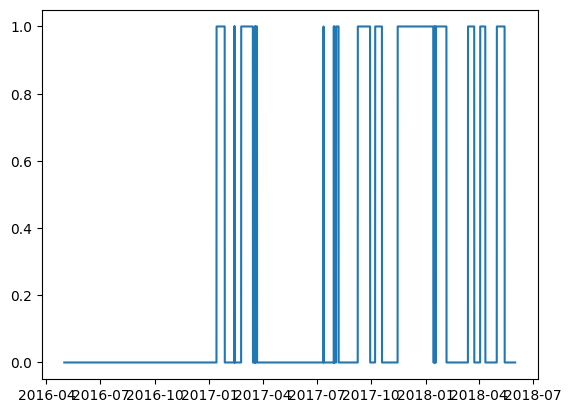

In [63]:
plt.plot(enough_matches_per_nbr["ams4"])

In [39]:
df

id,ams4,ams5,ams14,ams16,ams17,ams18,ams19,ams20,ams22,ams23,...,ams97,ams98,ams99,ams101,ams102,ams103,ams104,ams105,ams106,ams107
time,,,,,,,,,,,,,,,,,,,,,
2016-05-01 00:05:00,NaN,NaN,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,...,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN
2016-05-01 00:10:00,NaN,NaN,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,...,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN
2016-05-01 00:15:00,NaN,NaN,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,...,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN
2016-05-01 00:20:00,NaN,NaN,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,...,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN
2016-05-01 00:25:00,NaN,NaN,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,...,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-05-31 23:40:00,0.0,0.0,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0
2018-05-31 23:45:00,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,0.0,0.0
2018-05-31 23:50:00,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0


In [31]:
# ds_so_filter = so_filter(ds_station.rainfall, ds_neighbors.rainfall, window_length=mint)
da_station = ds_station.rainfall
da_neighbors = ds_neighbors.rainfall
window_length =mint

s_station = da_station.to_series()
s_neighbors = da_neighbors.to_series()

#create dataframe of neighboring stations
df = da_neighbors.to_dataframe()
df = df["rainfall"].unstack("id")

KeyboardInterrupt: 

In [ ]:


corr = s_station.rolling(window_length, min_periods= 1).corr(s_neighbors)

# number of matching rainy time steps in evaluation period
number_of_rainy_neighbors  = (df > 0).sum(axis=1)
rainy_timestep_at_station = s_station > 0

#this is not correct it sums ALL nbrs
matches = number_of_rainy_neighbors.where(rainy_timestep_at_station).rolling(mint, min_periods=1).sum()
ds = xr.Dataset.from_dataframe(pd.DataFrame({'corr': corr}))
ds['matches'] = xr.DataArray.from_series(matches)

### RUN SO FILTER

In [78]:
%%time

for i in [16, 26, 36, 46, 56]: # range(len(ds_pws.id)):
    
    # create data set for station i
    ds_station = ds_pws.isel(id=i) 
    pws_id = ds_station.id.values

    # picking stations within max_distnance, excluding itself, for the whole duration of the time series
    neighbor_ids = distance_matrix.id.data[(distance_matrix.sel(id=pws_id) < max_distance) & (distance_matrix.sel(id=pws_id) > 0)]

    #create data set for neighbors
    ds_neighbors = ds_pws.sel(id=neighbor_ids)

    # if there are no observations in the time series, filter cannot be applied to the whole time series
    if ds_pws.rainfall.sel(id=pws_id).isnull().all():
        ds_pws.so_flag[i, :] = -1
        ds_pws.median_corr_nbrs[i,:] = -1
        continue

    # if there are not enough stations nearby, filter cannot be applied to the whole time series
    elif (len(neighbor_ids) < n_stat):
        ds_pws.so_flag[i, :] = -1
        ds_pws.median_corr_nbrs[i,:] = -1
        continue 
        
    else: 

    # run so-filter
        ds_so_filter = so_filter(ds_station.rainfall, ds_neighbors.rainfall, window_length=mint)

        median_correlation = ds_so_filter.corr.median(dim='id', skipna = True)
        ds_pws.median_corr_nbrs[i] = median_correlation
        
        so_array = (median_correlation < gamma).astype(int)
        
    # filter can not be applied if less than n_stat neighbors have enough matches
        ds_pws.so_flag[i] = xr.where(ds_so_filter.matches < n_stat, -1, so_array)

    # disregard warm up period
        ds_pws.so_flag[i, 0:mint] = -1
        
# ds_pws.to_netcdf('C:/Users/a002461/OPENSENSE/data/fourth_SO_flags_test.nc')

CPU times: total: 2min 3s
Wall time: 2min 3s


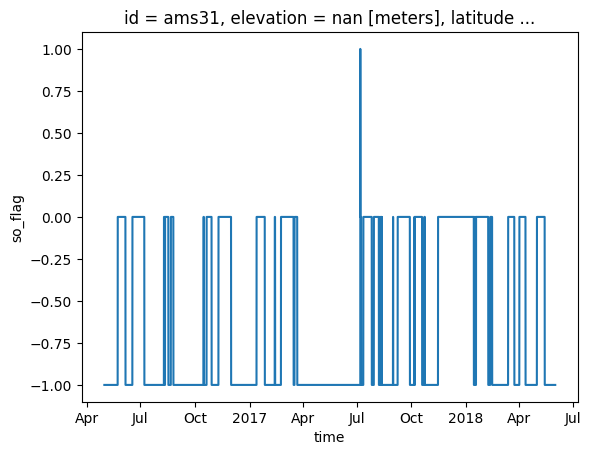

In [36]:
# mint = 4032 (två veckor), mmatch = 200
ds_pws.so_flag.sel(id = "ams31").plot()

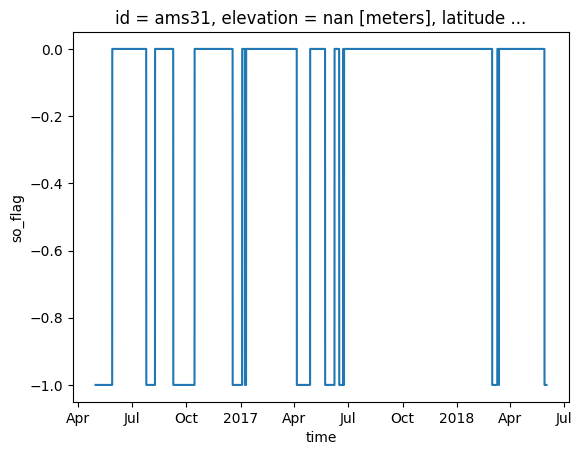

In [39]:
# mint = 8064 (four weeks), mmatch = 200
ds_pws.so_flag.sel(id = "ams31").plot()

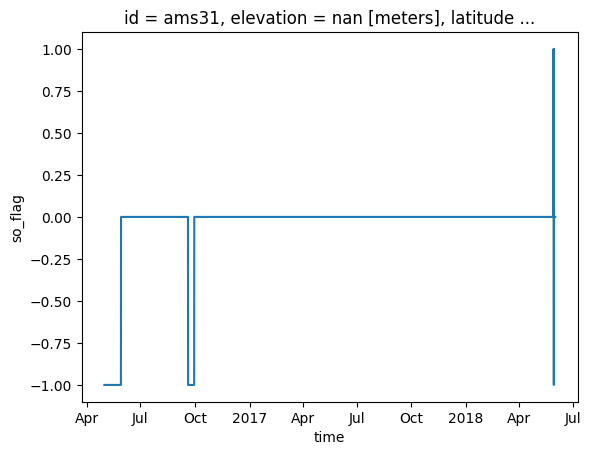

In [42]:
ds_pws.so_flag.sel(id = "ams31").plot()

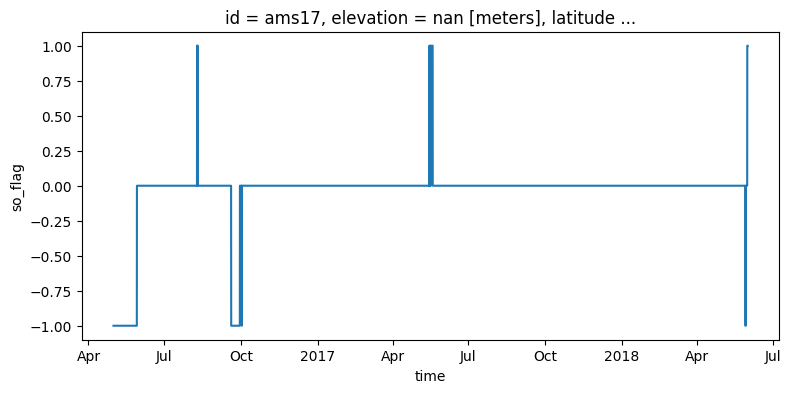

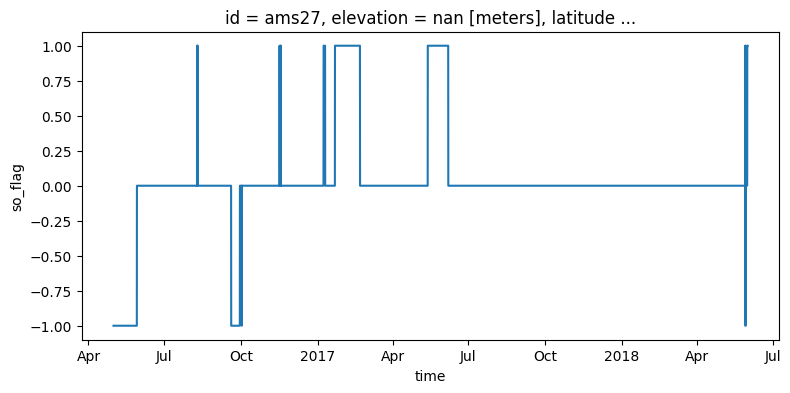

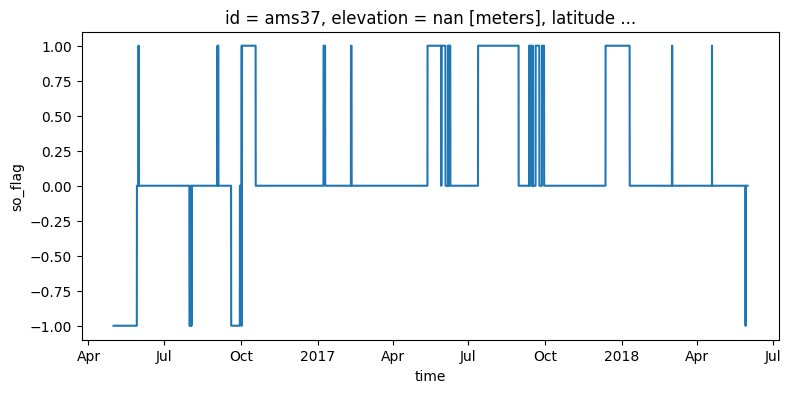

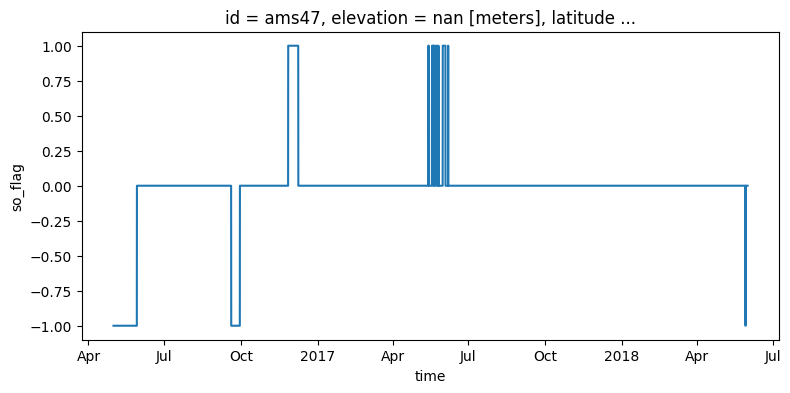

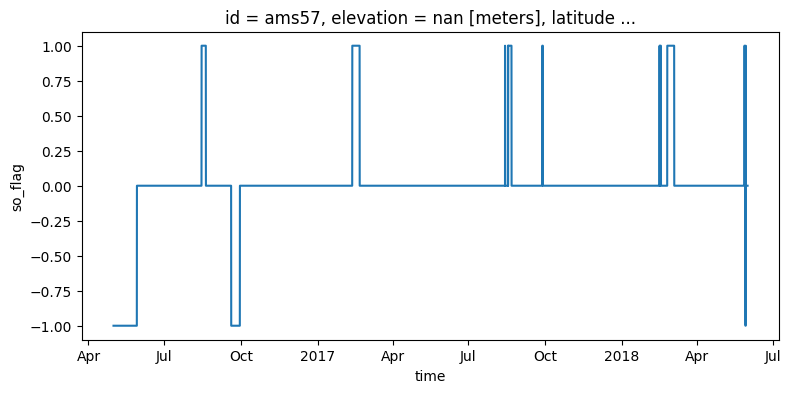

In [79]:
for i in [16, 26, 36, 46, 56]:
    fig, axs = plt.subplots(1,1, sharex = True, figsize = (9,4))
    k = i+1
    
    #SO
    ds_pws.isel(id = i).so_flag.plot()
    # axs[0].title.set_text('Louises SO flags ams%i' %k )

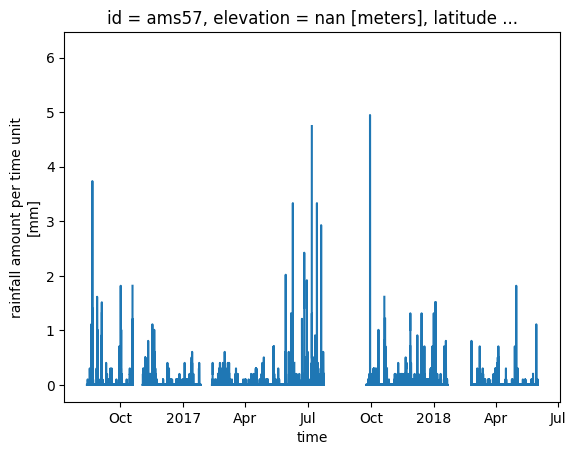

In [73]:
ds_pws.rainfall.sel(id = "ams57").plot()

### Old version below

In [ ]:
%%time

for i in [30]: # range(len(ds_pws.id)):
    
    # create data set for station i
    ds_station = ds_pws.isel(id=i) 
    pws_id = ds_station.id.values

    # picking stations within max_distnance, excluding itself, for the whole duration of the time series
    neighbor_ids = distance_matrix.id.data[(distance_matrix.sel(id=pws_id) < max_distance) & (distance_matrix.sel(id=pws_id) > 0)]

    #create data set for neighbors
    ds_neighbors = ds_pws.sel(id=neighbor_ids)

    # if there are no observations in the time series, filter cannot be applied to the whole time series
    if ds_pws.rainfall.sel(id=pws_id).isnull().all():
        ds_pws.so_flag[i, :] = -1
        ds_pws.median_corr_nbrs[i,:] = -1
        continue

    # if there are not enough stations nearby, filter cannot be applied to the whole time series
    elif (len(neighbor_ids) < n_stat):
        ds_pws.so_flag[i, :] = -1
        ds_pws.median_corr_nbrs[i,:] = -1
        continue 
        
    else: 

    # run so-filter
        ds_so_filter = so_filter(ds_station.rainfall, ds_neighbors.rainfall, window_length=mint)

        median_correlation = ds_so_filter.corr.median(dim='id', skipna = True)
        ds_pws.median_corr_nbrs[i] = median_correlation
        
        so_array = (median_correlation < gamma).astype(int)
        
        
    # check if enough matching rainy intervals in the rolling (fixed) evaluation period
        ds_pws.so_flag[i] = xr.where(ds_so_filter.matches < mmatch, -1, so_array)
        

    # filter can be applied if more than n_stat neighbors have enough matches
    more_than_nstat_nbrs = (nr_nbrs_with_enough_matches > n_stat)

    # disregard warm up period
        ds_pws.so_flag[i, 0:mint] = -1
        
# ds_pws.to_netcdf('C:/Users/a002461/OPENSENSE/data/fourth_SO_flags_test.nc')

In [ ]:
so_flag = pypwsqc.flagging.so_filter(
    ds_pws,
    distance_matrix,
    mint = 4032,
    mmatch = 200,
    gamma = 0.15,
    n_stat = 5,
    max_distance = 10e3,
)

In [19]:
#so_flag = pypwsqc.flagging.so_filter(
#    ds_pws.rainfall,
#    ds_pws.nbrs_not_nan,
#    ds_pws.reference,
#    distance_matrix,
#    mint = 4032,
#    mrain = 100,
#    mmatch = 200,
#    gamma = 0.15,
#   beta = 0.2,
#    n_stat = 5,
#    max_distance = 10e3,
#)